In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.animation import FuncAnimation
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

import os
import glob
import pandas as pd
import json
from functools import partial

from utils.db_tools import (
    db_init, metrics_grid, plot_grid, 
    get_data, filter_df, make_animation, 
    plot_all_trajectories)

In [2]:
model = "gray_scott"
run_id = "new_ball"
df, output_dir = db_init(model, run_id)

df["op"] = df["original_point"].astype(str)
df["ic"] = df["initial_condition"].astype(str)
df["du_dv"] = df.original_point.apply(lambda op: str(op["Du"]) + str(op["Dv"]))
df['ratio_b_a'] = df['B'] / df['A']
df['ratio_dv_du'] = df['Du'] / df['Dv']

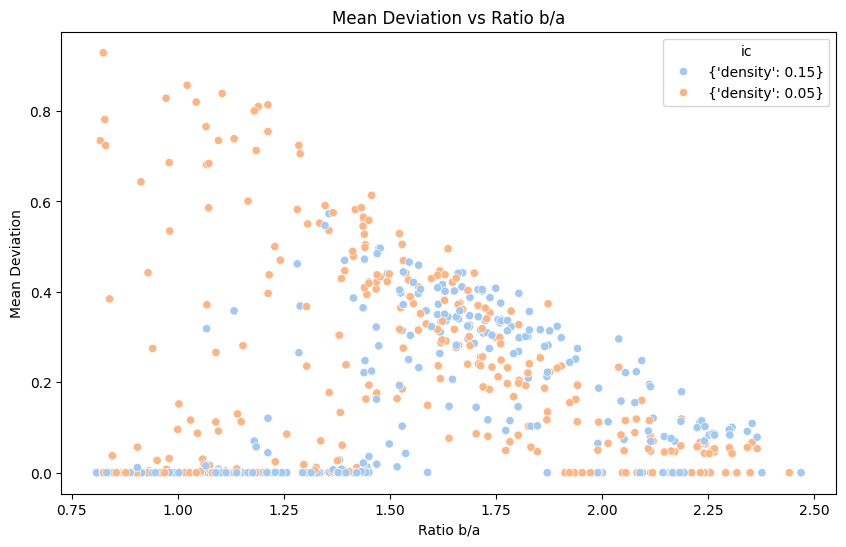

In [3]:
sns.set_palette("pastel")
# for dudv, df1 in df.groupby("du_dv"):
#     print(dudv)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='ratio_b_a', y='rel_std_u', hue="ic")
plt.xlabel('Ratio b/a')
plt.ylabel('Mean Deviation')
plt.title('Mean Deviation vs Ratio b/a')
# plt.xscale('log')
# plt.yscale('log')
plt.show()

In [4]:
# for op, df1 in df.groupby("op"):
#     fig = plot_ball_behavior(df1, start_frame=80, metric="std", joint=False)
#     fig.show()

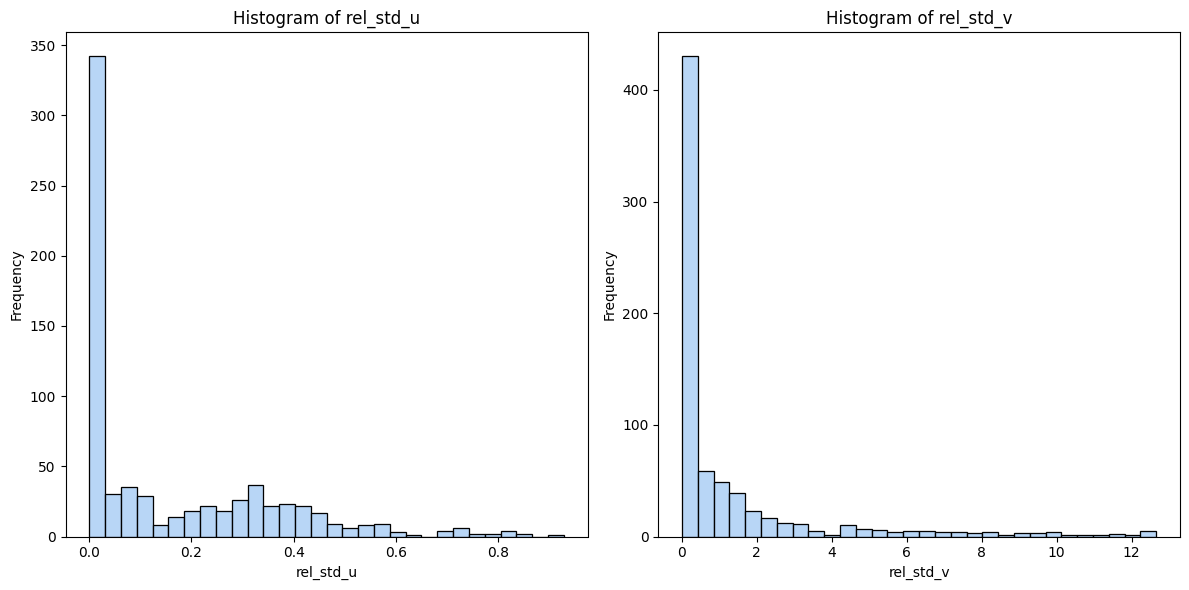

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(df['rel_std_u'], bins=30, ax=axes[0])
axes[0].set_xlabel('rel_std_u')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of rel_std_u')

sns.histplot(df['rel_std_v'], bins=30, ax=axes[1])
axes[1].set_xlabel('rel_std_v')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of rel_std_v')
plt.tight_layout()
plt.show() 

In [6]:
df_u = df[df.rel_std_u < 1e-1]
# print(len(df), len(df_u))
# sns.histplot(df_u, x="rel_std_v", hue="ic", multiple="stack")
df_conv = df_u[df_u.rel_std_v < 4]
df_int = df_u[df_u.rel_std_v >= 4]

In [7]:
df1 = df_conv.sample(n=5)
df2 = df_int.sample(n=5)
df1 = df1.reset_index()
df2 = df2.reset_index();

In [8]:
start_frame = 0

0    0.000009
1    0.004482
2    0.000000
3    0.000000
4    0.000000
Name: rel_std_v, dtype: float64


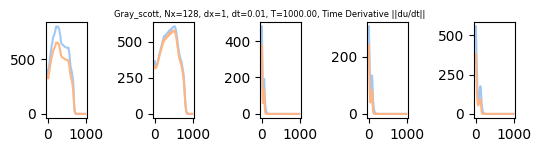

In [9]:
print(df1["rel_std_v"])
# metrics_grid(df1, start_frame, var1="", metric="std", scale=0.3);
metrics_grid(df1, 0, var1="", metric="dt", scale=0.3);

# for i, row in df1.iterrows():
#     make_animation(get_data(row), i, "out/gs")

In [17]:
df_int.sort_values("mean_dt")["mean_dt"]

113     0.000000
124     0.000000
233     0.000000
207     0.000000
348     0.000000
351     0.000000
594     0.000000
214     0.001318
523     0.001807
275     0.005564
298     0.008350
671     0.008926
476     0.017853
635     0.018014
665     0.021158
621     0.034655
155     0.047028
258     0.054329
114     0.057028
334     0.087578
171     0.101999
595     0.109947
490     0.202971
700     0.384373
566     0.413793
340     0.481197
152     0.871255
396     0.889030
519     0.967280
221     1.016230
38      1.109329
162     1.116227
578     1.149665
374     1.434371
513     1.933539
41      1.991588
576     2.078557
121     2.311297
465     2.347518
552     2.484899
517     2.852454
445     2.896091
420     3.342470
343     4.533983
598     4.559088
306     5.253980
471     5.329750
318     5.891335
512     7.423477
54     10.294156
497    12.360746
232    25.999334
575    42.913063
534    55.400391
Name: mean_dt, dtype: float64

In [18]:
df_filt = df_int[df_int.mean_dt > 5]
for i, row in df_filt.iterrows():
    d = get_data(row)
    make_animation(d, f"int_{i}", "out/gs/")

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


In [19]:
df_filt.loc[534]

model                                                       gray_scott
A                                                             0.037506
B                                                             0.077909
Nx                                                                 128
dx                                                                   1
Nt                                                              100000
dt                                                                0.01
Du                                                            0.187498
Dv                                                            0.055323
initial_condition                                    {'density': 0.05}
random_seed                                                 4109015880
n_snapshots                                                        100
filename             /cluster/scratch/vogtva/data/gray_scott/new_ba...
run_id                                                        new_ball
origin

In [12]:
for i, row in df2.iterrows():
    make_animation(get_data(row), f"std_{i}", "out/gs")

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


In [1]:
df_splitting = df2.iloc[1:2]
df_splitting.to_json()

NameError: name 'df2' is not defined